In [6]:
# Script developed by Cíntia Eleutério (2025)

import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dropout, Dense, concatenate
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# External data files for each gauging station
stations = {
    "Caracarai": "caracarai.csv",
    "Cucuí": "cucui.csv",
    "Moura": "moura.csv",
    "Santa_Maria_do_Boiacu": "santa_maria_do_boiacu.csv",
    "Serrinha": "serrinha.csv"
}

# Subnetwork configurations specific to each station
subnet_config = {
    "Caracarai": {"filters": 64, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
    "Cucuí": {"filters": 64, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
    "Moura": {"filters": 32, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
    "Santa_Maria_do_Boiacu": {"filters": 32, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
    "Serrinha": {"filters": 32, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
}

# Function to create a CNN subnetwork for a station
def create_subnet(input_layer, filters, kernel_size, pool_size, dropout_rate):
    """
    Creates a CNN subnetwork with Conv1D, MaxPooling, Dropout layers, and flattening.
    Args:
        input_layer: Keras Input layer for the station.
        filters: Number of convolutional filters.
        kernel_size: Size of the convolutional kernel.
        pool_size: Size of the max pooling window.
        dropout_rate: Dropout rate for regularization.
    Returns:
        Flattened output tensor of the subnetwork.
    """
    x = Conv1D(filters=filters, kernel_size=min(kernel_size, input_layer.shape[1]),
               activation='relu', padding='same')(input_layer)
    x = Conv1D(filters=filters * 2, kernel_size=min(kernel_size, input_layer.shape[1]),
               activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=min(pool_size, input_layer.shape[1]))(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters=filters, kernel_size=min(kernel_size, x.shape[1]),
               activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=min(pool_size, x.shape[1]))(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)
    return x

# Function to preprocess station data
def process_data(file_path):
    """
    Reads CSV data for a station, scales inputs and outputs, and reshapes for CNN input.
    Args:
        file_path: Path to the station CSV file.
    Returns:
        X: Input features (previous 10 years, scaled).
        Y: Target output (next year, scaled).
        scaler_y: Scaler object for inverse transforming predictions.
    """
    df = pd.read_csv(file_path)
    
    # Use last 10 years as input (assuming each column corresponds to a year)
    X = df.iloc[:, -13:-3].values / 100  # Scaling to meters
    Y = df.iloc[:, -3].values / 100      # Target year (2021)
    
    # Scale input and output
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X = scaler_x.fit_transform(X)
    Y = scaler_y.fit_transform(Y.reshape(-1, 1))
    
    # Reshape for Conv1D (samples, timesteps, features)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    return X, Y, scaler_y

# Preprocess data for all stations
station_data = {station: process_data(file) for station, file in stations.items()}

# Create input layers and subnets for each station
inputs = {}
subnets = {}

for station, config in subnet_config.items():
    input_layer = Input(shape=(10, 1), name=f"input_{station}")  # Input shape for 10 years
    subnet = create_subnet(input_layer, **config)
    inputs[station] = input_layer
    subnets[station] = subnet

# Merge all subnet outputs
merged = concatenate(list(subnets.values()), name="merged_layer")

# Fully connected layers after merging
dense_1 = Dense(60, activation='relu', kernel_regularizer=l2(0.05))(merged)
dense_2 = Dense(30, activation='relu', kernel_regularizer=l2(0.05))(dense_1)
output = Dense(1, name="output_layer")(dense_2)  # Final output for water level prediction

# Build and compile the model
model = Model(inputs=list(inputs.values()), outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Combine data from all stations for training
X_train = np.concatenate([station_data[station][0] for station in stations], axis=0)
Y_train = np.concatenate([station_data[station][1] for station in stations], axis=0)

# Split dataset into training and validation sets (70% training, 30% validation)
split_idx = int(0.7 * X_train.shape[0])
X_val, Y_val = X_train[split_idx:], Y_train[split_idx:]
X_train, Y_train = X_train[:split_idx], Y_train[:split_idx]

# Prepare data for all subnet inputs
X_train_all_stations = [X_train for _ in stations]  # Same input data for all station subnets
X_val_all_stations = [X_val for _ in stations]

# Train the model
history = model.fit(X_train_all_stations, Y_train, 
                    epochs=200, 
                    validation_data=(X_val_all_stations, Y_val), 
                    verbose=1)

# Generate predictions and save to CSV for each station
for station in stations:
    X_test, Y_test, scaler_y = station_data[station]
    
    # Predict using the model (same input for all subnet entries)
    predictions = model.predict([X_test for _ in stations])
    predictions_rescaled = scaler_y.inverse_transform(predictions)
    
    # Rescale observed data
    Y_real_rescaled = scaler_y.inverse_transform(Y_test)
    
    # Create DataFrame with observed and predicted values
    output_df = pd.DataFrame({
        "Observed": Y_real_rescaled.flatten(),
        "Predicted": predictions_rescaled.flatten()
    })
    
    # Save predictions to CSV
    output_df.to_csv(f"{station}_predictions.csv", index=False)
    print(f"File {station}_predictions.csv saved successfully!")


Epoch 1/200


/home/carlos/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_Caracarai', 'input_Cucuí', 'input_Moura', 'input_Santa_Maria_do_Boiacu', 'input_Serrinha']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 5.9869 - mae: 0.2626 - val_loss: 2.8202 - val_mae: 0.1016
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2822 - mae: 0.1176 - val_loss: 1.1390 - val_mae: 0.0979
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9475 - mae: 0.1068 - val_loss: 0.5344 - val_mae: 0.0933
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4615 - mae: 0.1047 - val_loss: 0.2920 - val_mae: 0.1066
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2537 - mae: 0.1068 - val_loss: 0.1632 - val_mae: 0.0863
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1457 - mae: 0.0982 - val_loss: 0.0971 - val_mae: 0.0907
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0867 - mae: 0.0980 - val_loss: 0.0599 - val_mae: 0.0898
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0541 - mae: 0.0942 - val_loss: 0.0450 - val_mae: 0.1046
Epoch 9/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0350 - mae: 0.

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0550 - val_loss: 0.0153 - val_mae: 0.0896
Epoch 56/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - mae: 0.0537 - val_loss: 0.0128 - val_mae: 0.0818
Epoch 57/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mae: 0.0545 - val_loss: 0.0181 - val_mae: 0.1056
Epoch 58/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0064 - mae: 0.0533 - val_loss: 0.0154 - val_mae: 0.0904
Epoch 59/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - mae: 0.0546 - val_loss: 0.0118 - val_mae: 0.0762
Epoch 60/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065 - mae: 0.0533 - val_loss: 0.0124 - val_mae: 0.0774
Epoch 61/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - mae: 0.0520 - val_loss: 0.0123 - val_mae: 0.0786
Epoch 62/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - mae: 0.0526 - val_loss: 0.0127 - val_mae: 0.0802
Epoch 63/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - 

Epoch 109/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0438 - val_loss: 0.0134 - val_mae: 0.0855
Epoch 110/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mae: 0.0429 - val_loss: 0.0151 - val_mae: 0.0760
Epoch 111/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0447 - val_loss: 0.0138 - val_mae: 0.0860
Epoch 112/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - mae: 0.0415 - val_loss: 0.0112 - val_mae: 0.0752
Epoch 113/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - mae: 0.0424 - val_loss: 0.0103 - val_mae: 0.0726
Epoch 114/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - mae: 0.0395 - val_loss: 0.0114 - val_mae: 0.0777
Epoch 115/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - mae: 0.0387 - val_loss: 0.0121 - val_mae: 0.0805
Epoch 116/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mae: 0.0402 - val_loss: 0.0109 - val_mae: 0.0746
Epoch 117/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/tmp/ipykernel_9508/31888844.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


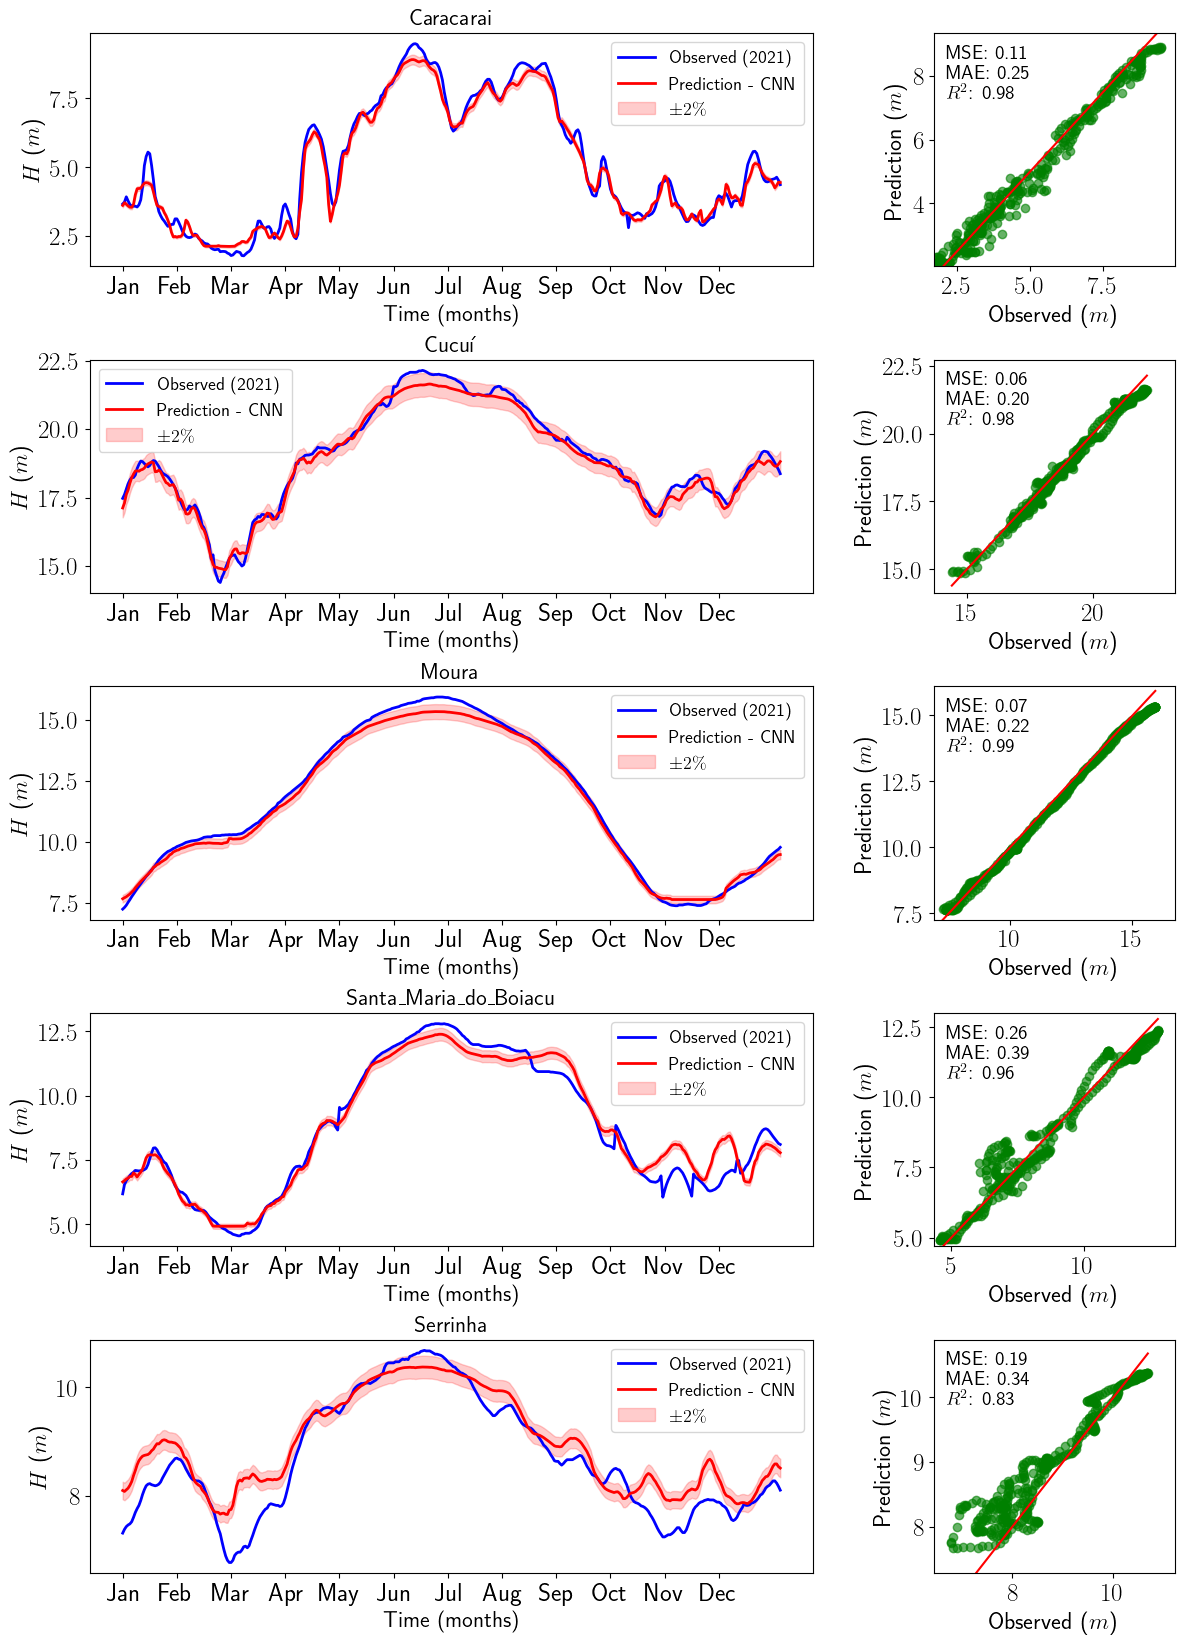

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set global plotting parameters for consistency and LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 15})
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16

# Create subplots: one row per station, two columns (line plot + scatter plot)
n_stations = len(stations)
fig, axs = plt.subplots(n_stations, 2, figsize=(14, n_stations * 4), 
                        gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.25, 'hspace': 0.4})

# Define month labels for x-axis
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Loop over stations to plot results
for i, station in enumerate(stations.keys()):
    # Retrieve preprocessed test data for the station
    X_test, Y_test, scaler_y = station_data[station]

    # Generate predictions using the trained model
    predictions = model.predict([X_test for _ in stations])
    predictions_rescaled = scaler_y.inverse_transform(predictions)
    Y_real_rescaled = scaler_y.inverse_transform(Y_test)
    
    # Compute error metrics: MSE, MAE, RMSE, R^2
    mse = mean_squared_error(Y_real_rescaled, predictions_rescaled)
    mae = mean_absolute_error(Y_real_rescaled, predictions_rescaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_real_rescaled, predictions_rescaled)

    # Compute ±2% range around predicted curve for visualization
    lower_bound = predictions_rescaled[:365] * 0.98
    upper_bound = predictions_rescaled[:365] * 1.02

    # -------------------------
    # Line plot (left column)
    # -------------------------
    axs[i, 0].plot(Y_real_rescaled[:365], label="Observed (2021)", color='blue', linewidth=2)
    axs[i, 0].plot(predictions_rescaled[:365], label="Prediction - CNN", color='red', linestyle='-', linewidth=2)
    axs[i, 0].fill_between(range(365), lower_bound.flatten(), upper_bound.flatten(), color='red', alpha=0.2, label="$\pm 2\%$")
    
    # Set title dynamically based on station name
    axs[i, 0].set_title(f"{station}", fontsize=16)
    
    # Set x-axis as months
    axs[i, 0].set_xlabel("Time (months)", fontsize=16)
    axs[i, 0].set_ylabel("$H$ ($m$)", fontsize=17)
    axs[i, 0].set_xticks([i * 30 for i in range(12)])
    axs[i, 0].set_xticklabels(months, fontsize=18)
    
    axs[i, 0].legend(fontsize=13)

    # -------------------------
    # Scatter plot (right column)
    # -------------------------
    axs[i, 1].scatter(Y_real_rescaled, predictions_rescaled, alpha=0.6, color='green')
    axs[i, 1].plot([Y_real_rescaled.min(), Y_real_rescaled.max()],
                   [Y_real_rescaled.min(), Y_real_rescaled.max()],
                   color='red', linestyle='-')  # 1:1 line
    
    axs[i, 1].set_xlabel("Observed ($m$)", fontsize=17)
    axs[i, 1].set_ylabel("Prediction ($m$)", fontsize=17)
    
    # Scatter plot axis limits automatically
    axs[i, 1].set_xlim(Y_real_rescaled.min() * 0.95, Y_real_rescaled.max() * 1.05)
    axs[i, 1].set_ylim(predictions_rescaled.min() * 0.95, predictions_rescaled.max() * 1.05)
    
    # Add MSE, MAE, R^2 text to scatter plot
    axs[i, 1].text(0.05, 0.95, f"MSE: {mse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}",
                   transform=axs[i, 1].transAxes,
                   fontsize=14, verticalalignment='top', color='black')

# Adjust layout and save the figure as PDF
plt.tight_layout()
plt.savefig('prediction_individual_ranges.pdf', format='pdf', bbox_inches='tight')
plt.show()
